# IEOR 243 Group 10 Module 2


We want to address the following questions through code and our report:

#### What is the goal of our models and what are you trying to achieve?

Our general goal is to understand how people felt about COVID in 2020 and compare it to how people felt about COVID in 2023. We also want to be more specific than a simple sentiment analysis in which we score sentiment on a -10 to 10 scale (or something comparable). We want to be able to capture the full range of emotions that people convey about COVID. For instance, people may be sad about losing a loved one, scared about getting sick or losing money, angry (or happy) about policy created by legislators, etc. These emotions should not be abstracted into a single number necessarily. 

#### What models and methodologies have you used?

We are in an interesting scenario because our data is *not labeled* meaning we cannot train any supervised learning models to predict sentiment, emotions, etc. We have over 100k rows so manually labeling the data is infeasible. Instead, we introduce three modeling approaches to analyze our problem.

1) **K-Means Clustering**: We begin by creating a K-Means clustering algorithm on the `text` column in our data to understand the general trends of communication. 

    * **K-Means Clusters as Labels**: We then sample tweets from each cluster, cobmine them together, and run inference on a pre-trained summarization model to arrive as cluster descriptions to use with our Zero-Shot models later.


2) **Zero-Shot Classification with Hugging Face SOTA**: Hugging Face hosts many open-source, pre-trained models for sentiment analysis and text-classification. We'll apply a few of these models for zero-shot classification on our data to see how it performs. This is difficult to compare to an unsupservised model, but gives us a more useful model. 


3) **Unsupervised Text Classification through Lbl2Vec**: Lbl2Vec is a rather new algorithm published in 2021 (paper: https://www.scitepress.org/Link.aspx?doi=10.5220/0010710300003058) which automatically generates jointly embedded label, document and word vectors and returns documents of categories modeled by manually predefined keywords. The key idea of the algorithm is that many semantically similar keywords can represent a category. We'll compare this to the zero-shot learning from Hugging Face, along with our K-Means clustering to see how it performsn.

#### How have you selected any tuning parameters for your models (a.k.a hyperparameters)?

While most supervised learning algorithms benefit greatly from using a standard K-Fold cross-validation implementation using Scikit-Learn's `GridSearchCV` object, for K-Means clustering, it's quite common to use the "elbow method." Instead of directly minimizing some evaluation metric like SSE or Inertia, we instead will search over a space of reasonable values of `n_clusters` and plot the corresponding silhouette scores. We will select a quasi-optimal value of `n_clusters` by selecting the one on the "elbow" of the plot.

#### How well does your model perform and how have you measured that?


#### Are there any significant limitations to your modeling methods (i.e. Where, when, how, and why can your model fail? )


In [1]:
# General Imports 
import pandas as pd
import numpy as np
import re
import random
import matplotlib.pyplot as plt
from typing import List
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Modeling Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from sentence_transformers import SentenceTransformer

## Preprocessing

First, we load in the uncleaned data and apply the data cleaning steps from Module 1. Please refer to the `ieor_243_group_10_module_1.ipynb` notebook for an in-depth explanation of this process.

In [3]:
# Load data 
parent_path = "../data"
df20 = pd.read_csv(f"{parent_path}/covid2020.csv")
df23 = pd.read_csv(f"{parent_path}/covid2023.csv")

In [4]:
# Preprocessing Helper Functions
def preprocess_text(text: str) -> str:
    
    """
    Processes a tweet string by removing any weird string characters/formattings
    Args: 
        - text (str): the text to clean
    Returns: 
        - clean_text (str): the cleaned text string
    """
    # convert to lowercase
    text = text.lower()
    
    # remove URLs
    text = re.sub(r"http\S+", "", text)

    # Removing Emojis
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Removing emoticons
    text = re.sub(r':\w+:', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    # Removing Contractions
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    clean_text = text
    
    return clean_text

def preprocess_nulls(df: pd.DataFrame) -> pd.DataFrame: 
    
    """
    Removes nulls and 0 counts from a dataframe
    Args: 
        - df (pd.DataFrame): the dataframe to remove nulls from
    Returns: 
        - clean_df (str): the cleaned df
    """
    
    # Drop duplicate rows 
    df = df.drop_duplicates(subset = "text")
    
    # Drop rows with no followers 
    df = df[df['user_followers'] > 0]
    
    # Drop nulls and reset index 
    df = df.dropna().reset_index(drop = True)
    
    clean_df = df
    
    return clean_df

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Main processing function on the dataframe
    Args: 
        - df (pd.DataFrame): df of tweets to process
    Returns: 
        - preprocessed_df (pd.DataFrame): the processed df
    """
    
    # Preprocess null and missing values 
    df = preprocess_nulls(df)
    
    # Preprocess text 
    df['processed_text'] = df['text'].apply(preprocess_text)            
    
    return df

In [5]:
# Process the data and extract text columns
df20_processed = preprocess_df(df20)
df23_processed = preprocess_df(df23)

## Construct Word Embeddings

Now we can load in a Word2Vec style word-embedding model to get better vector representations than can be found using TFIDF.

In [6]:
# Sample from DF
df20_sampled = df20_processed.sample(frac = 0.25)
df23_sampled = df23_processed.sample(frac = 0.25)

X20 = df20_sampled['processed_text'].to_list()
X23 = df23_sampled['processed_text'].to_list()

Don't run this cell unless you want to wait for a super super long time!

In [54]:
# # Get word vector embeddings 
# embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# X20_embeddings = embedding_model.encode(X20)

## Step #1: K-Means Clustering (Unsupervised)

We search over a space `n_cluster` values from 2 to 9 and use the elbow method to select the value with the highest `silhouette_score` as our final model. We then plot the results below.

In [55]:
def train_kmeans(X, n_cluster_values: List[int], verbose: bool = True) -> dict: 
    
    """
    Function to train KMeans and run a parameter sweep over n_cluster_values 
    Params: 
        - X: data to train on
        - n_cluster_values: list of integers of the number of clusters to try
        - random_seed: random seed to pass to KMeans estimator 
        v- erbose: bool
    Returns: 
        - scores: dictionary of silhouette scores for each n_clusters value
    """
    
    # Search over a search space of n_cluster values 
    scores = {}
    tic = time.time()
    for n_clusters in n_cluster_values: 

        # Fit a model 
        kmeans = KMeans(n_clusters = n_clusters, random_state = 1)
        kmeans.fit(X)


        # Compute the silhouette score
        score = silhouette_score(X = X, 
                                 labels = kmeans.labels_, 
                                 metric = 'euclidean'
                                )
        scores.update({n_clusters: score})

        # Logging 
        if verbose: 
            print(f"n_clusters: {n_clusters} -- {time.time()-tic:2f} seconds")
            
    return scores

In [80]:
# Train the KMeans Estimator 
scores = train_kmeans(X = X20_embeddings, 
                      n_cluster_values = list(range(2, 16)), 
                      verbose = True)

n_clusters: 2 -- 70.609305 seconds
n_clusters: 3 -- 132.596795 seconds
n_clusters: 4 -- 212.960151 seconds
n_clusters: 5 -- 325.201891 seconds
n_clusters: 6 -- 400.130752 seconds
n_clusters: 7 -- 469.824356 seconds
n_clusters: 8 -- 536.437006 seconds
n_clusters: 9 -- 604.055185 seconds
n_clusters: 10 -- 669.188954 seconds
n_clusters: 11 -- 732.108650 seconds
n_clusters: 12 -- 795.288000 seconds
n_clusters: 13 -- 867.792250 seconds
n_clusters: 14 -- 938.302706 seconds
n_clusters: 15 -- 1023.902612 seconds


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


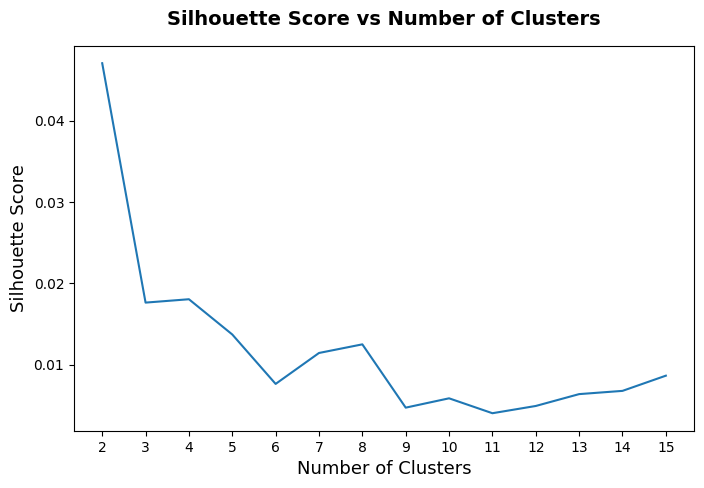

In [81]:
# Plot the Silhouette score results
fig, ax = plt.subplots(figsize = (8,5))

n_cluster_vals = list(scores.keys())
n_cluster_scores = list(scores.values())

plt.plot(n_cluster_vals, n_cluster_scores)

plt.title("Silhouette Score vs Number of Clusters", pad = 15, fontweight = 'semibold', fontsize = 14)
plt.xlabel("Number of Clusters", fontsize = 13)
plt.ylabel("Silhouette Score", fontsize = 13)

plt.xticks(n_cluster_vals, n_cluster_vals)
plt.show()

In [8]:
X20_embeddings = pd.read_csv('../data/X20_embeddings.csv')

In [10]:
# Extract the best model and retrain it
# optimal_n_clusters = list(scores.keys())[np.argmax(list(scores.values()))]
optimal_n_clusters = 8
kmeans = KMeans(n_clusters = optimal_n_clusters, random_state = 1, max_iter = 5_000)
kmeans.fit(X20_embeddings)

KMeans(max_iter=5000, random_state=1)

In [12]:
# Add predictions to df and check the cluster distribution
df20_sampled['cluster'] = kmeans.predict(X20_embeddings)
df20_sampled['cluster'].value_counts(normalize = True).sort_index()

0    0.141028
1    0.100057
2    0.041903
3    0.153955
4    0.100421
5    0.106298
6    0.155130
7    0.201208
Name: cluster, dtype: float64

In [96]:
# Add predictions to df and check the cluster distribution
df20_sampled['cluster'] = kmeans.predict(X20_embeddings)
df20_sampled['cluster'].value_counts(normalize = True)

7    0.201208
6    0.155130
3    0.153955
0    0.141028
5    0.106298
4    0.100421
1    0.100057
2    0.041903
Name: cluster, dtype: float64

## Step #2: Use Pretrained Transformer Models to Generate Class Keyword Tags

Now that we have a well trained KMeans clustering algorithm, we want to summarize (label) these clusters. One common approach is to look manually and determine what each cluster entails, but we are more principled than that. 

Instead, we'll use the ChatGPT API to generate a list of keyword tags for each cluster. Note, we could use an open-source model, but they often have high latency and a smaller allotted input size than ChatGPT. 

In [105]:
def get_cluster_tweets(cluster: int, n_tweets: int = 100): 
    
    t1 = df20_sampled[df20_sampled['cluster'] == cluster]['processed_text'].sample(n_tweets).to_list()
    
    for idx, tweet in enumerate(t1):
        tweet = tweet.replace("\n", "")
        print(f"({idx+1}) {tweet}")

**Prompt**: I am going to give you a list of 100 tweets. Your job is to come up with 3-5 keyword tags that apply to all of the tweets. You should focus on describing the general trend of the tweets. 

Many of the tweets contain information about COVID-19. You should not include "covid-19," "covid," "pandemic," or "coronavirus" as keywords, okay?

Here are the tweets: 


{INSERT TWEETS}

In [27]:
labels = {
    1: ['social issues', 'personal development', 'business and economics', 'community building'],
    2: ['india', 'updates', 'testing', 'fatalities', 'recoveries', 'healthcare'],
    3: ['face masks', 'safety', 'protection', 'public health', 'prevention'],
    4: ['social media', 'resilience', 'community support', 'online events'],
    5: ['global', 'cases', 'deaths', 'statistics'],
    6: ['politics', 'government response', 'public health', 'conspiracy', 'human rights'],
    7: ['health', 'information','vacccine', 'public awareness'],
    8: ['layoffs', 'misinofrmation', 'mental health', 'lockdown', 'access', 'financial impact', 'political response', 'education']
}

## Step #3: Zero-Shot Classification with Hugging Face 

https://huggingface.co/facebook/bart-large-mnli

In [28]:
# Combine all labels
list_of_labels = [item for sublist in list(labels.values()) for item in sublist]
list_of_labels = list(set(list_of_labels))

In [29]:
# Load in model 
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
# Run predictions on samples
samples = df20_sampled['processed_text'].sample(1_000).to_list()
preds = classifier(samples, list_of_labels)
pred_labels = [pred['labels'][0] for pred in preds]

In [165]:
pd.Series(pred_labels).value_counts(normalize = True)

information            0.22
deaths                 0.12
updates                0.10
testing                0.08
cases                  0.05
vacccine               0.05
recoveries             0.05
financial impact       0.03
lockdown               0.03
misinofrmation         0.03
india                  0.02
resilience             0.02
prevention             0.02
community support      0.02
global                 0.02
statistics             0.01
face masks             0.01
safety                 0.01
social media           0.01
politics               0.01
conspiracy             0.01
public awareness       0.01
political response     0.01
government response    0.01
public health          0.01
online events          0.01
human rights           0.01
protection             0.01
access                 0.01
dtype: float64